In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from zipfile import ZipFile

## Read in zip fil

In [63]:
#read in file path
zip_file_path = "archive.zip"

In [64]:
#open zipfile
with ZipFile(zip_file_path) as z:
    file_list = z.namelist()
    print(file_list)
    
    with z.open('Bank Customer Churn Prediction.csv') as f:
        df = pd.read_csv(f)
print(df.shape)        
df.head()

['Bank Customer Churn Prediction.csv']
(10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [21]:
#check for missing values
df.isnull().any()

customer_id         False
credit_score        False
country             False
gender              False
age                 False
tenure              False
balance             False
products_number     False
credit_card         False
active_member       False
estimated_salary    False
churn               False
dtype: bool

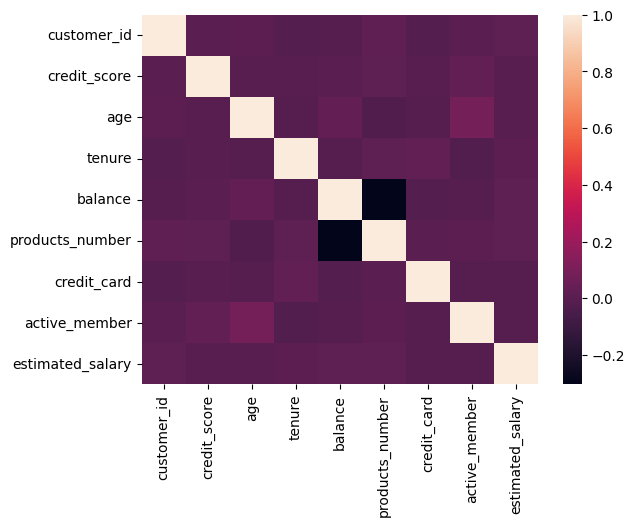

In [22]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="churn").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [65]:
#checking value counts of churn data
df["churn"].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: churn, dtype: float64

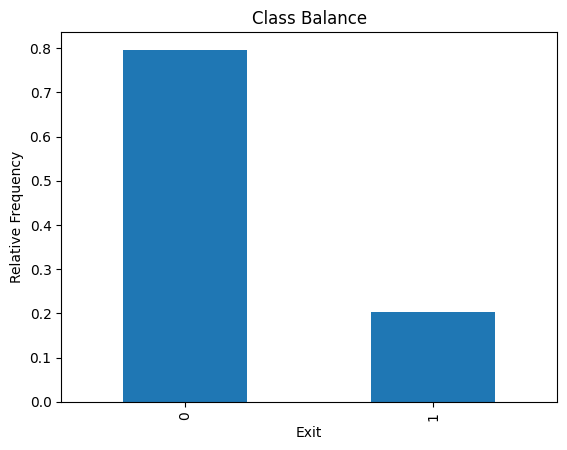

In [24]:
# Plot value counts of `"churn"`
df["churn"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Exit",
    ylabel="Relative Frequency",
    title="Class Balance"
);

In [25]:
#gender count
gender_counts = df["gender"].value_counts(normalize=True)
gender_counts

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

In [26]:
#the distribution of churn (Exited) within each gender
churn_by_gender = df.groupby("gender")["churn"].value_counts(normalize=True).unstack()
churn_by_gender

churn,0,1
gender,,
Female,0.749285,0.250715
Male,0.835441,0.164559


In [27]:
roof_pivot = pd.pivot_table(
    df,
    index="country",
    values="churn",
    aggfunc=np.mean
)
roof_pivot

,churn
country,
France,0.161548
Germany,0.324432
Spain,0.166734


## Data splitting 

In [28]:
target = "churn"
X = df.drop(columns=[target, "customer_id", "gender", "country"])
y = df[target]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 8)
y_train shape: (8000,)
X_test shape: (2000, 8)
y_test shape: (2000,)


## Baseline model

In [30]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.79


In [31]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [66]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.81
Test Accuracy: 0.81


In [70]:
# Predict on the test data
y_pred = model.predict(X_test)
y_pred[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [71]:
#decision tree model
model_1 = DecisionTreeClassifier(random_state=42)
model_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [73]:
#accuracy score for train and test set
act_train = model_1.score(X_train, y_train)
act_test = model_1.score(X_test, y_test)
print("Training Accuracy:", round(act_train, 2))
print("Test Accuracy:", round(act_test, 2))

Training Accuracy: 1.0
Test Accuracy: 0.78


In [74]:
#getting tree depth 
tree_depth = model_1.get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 30


In [75]:
#hyperparameter turning
depth_hyperparams = range(1, 29, 2)

In [78]:
# Create empty lists for training and testing accuracy scores
training_acc = []
testing_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(max_depth=d, random_state=42)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate testing accuracy score and append to `training_acc`
    testing_acc.append(test_model.score(X_test, y_test))

In [80]:
print("Training Accuracy Scores:", training_acc[:3])
print("test Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7945, 0.8455, 0.859375]
test Accuracy Scores: [0.8035, 0.8485, 0.858]


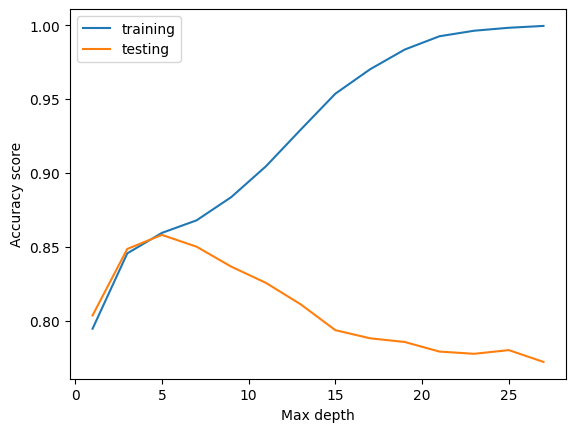

In [82]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, testing_acc, label="testing")
plt.xlabel("Max depth")
plt.ylabel("Accuracy score")
plt.legend();

In [83]:
best_depth_index = np.argmax(testing_acc)
best_max_depth = depth_hyperparams[best_depth_index]

print(f"Best max_depth: {best_max_depth}")

Best max_depth: 5


In [84]:
#retraing the model with best max_depth
model_1 = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
model_1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [86]:
act_train = model_1.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print("Train Accuracy:", round(act_train, 2))
print("Test Accuracy:", round(test_acc, 2))

Train Accuracy: 0.86
Test Accuracy: 0.81


In [87]:
test_pred = model_1.predict(X_test)
test_pred[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [95]:
#getting the feature importances
features = X_train.columns
importances = model_1.feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['credit_score', 'age', 'tenure'], dtype='object')
Importances: [0.00859111 0.43537216 0.00196137]


In [97]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head(10)

credit_card         0.000000
tenure              0.001961
credit_score        0.008591
estimated_salary    0.017780
balance             0.028032
active_member       0.168955
products_number     0.339308
age                 0.435372
dtype: float64

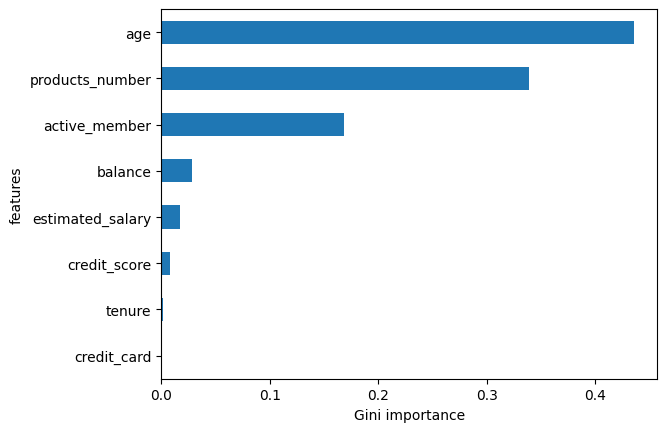

In [98]:
# Create horizontal bar chart
feat_imp.plot(kind="barh"),
plt.xlabel("Gini importance"),
plt.ylabel("features");